In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
cii_map = m_cii.maps

Loading .npz catalogues...


## 21cm Signal Modelization

In [4]:
halo_ms = m_cii.halos.M

In [5]:
def MH1_fit(M, M_0, M_min, alpha):
    x = M/M_min
    return M_0 * (x**alpha) * np.exp(-1/(x**0.35))

In [6]:
halo_HI = MH1_fit(halo_ms, (1.9*(10**9)), (2*(10**10)), (0.74))

In [15]:
rho_c = m_cii.cosmo_model.critical_density0

In [12]:
H_func = m_cii.cosmo_model.H

In [14]:
h = m_cii.cosmo_model.h

In [13]:
H_0 = m_cii.cosmo_model.H0

Getting HI Density

In [34]:
import scipy as sp

In [19]:
x,y,z = m_cii.mapinst.pix_binedges_x, m_cii.mapinst.pix_binedges_y, m_cii.mapinst.nu_binedges
t     = m_cii.mapinst.maps

In [28]:
def hubble(z,h,omegam):
    """
    H(z) in units of km/Mpc*s
    """
    return h*100*np.sqrt(omegam*(1+z)**3+1-omegam)

In [29]:
def drdz(z,h,omegam):
    return 299792.458 / hubble(z,h,omegam)

In [70]:
def redshift_to_chi(z, cosmo):
    """
    Transform from redshift to comoving distance
    Agrees with NED cosmology to 0.01% - http://www.astro.ucla.edu/~wright/CosmoCalc.html
    """
    zinterp = np.linspace(0,10,20000)
    dz      = zinterp[1] - zinterp[0]

    chiinterp  = np.cumsum(drdz(zinterp, cosmo.h, cosmo.Omega_M) * dz)
    chiinterp -= chiinterp[0]
    chi_of_z   = sp.interpolate.interp1d(zinterp,chiinterp)

    return chi_of_z(z)

In [36]:
zco = redshift_to_chi((m_cii.mapinst.nu_rest/z) -1 , m_cii.limlam_cosmo)

In [37]:
avg_ctd = np.mean(zco)
xco     = x/(180)*np.pi*avg_ctd
yco     = y/(180)*np.pi*avg_ctd

In [38]:
dxco, dyco, dzco = [np.abs(np.mean(np.diff(d))) for d in (xco, yco, zco)]

In [47]:
co_vol = dxco*dyco*dzco

In [79]:
co_vol

24.12891989966043

In [48]:
bins3D = [m_cii.mapinst.pix_binedges_x, m_cii.mapinst.pix_binedges_y, m_cii.mapinst.nu_binedges[::-1]]

In [76]:
tot_HI, _ = np.histogramdd( np.c_[m_cii.halos.ra, m_cii.halos.dec, m_cii.halos.nu], 
                                  bins    = bins3D, weights = halo_HI)
tot_HI = tot_HI[:,:,::-1]

In [77]:
rho_HI = tot_HI/co_vol

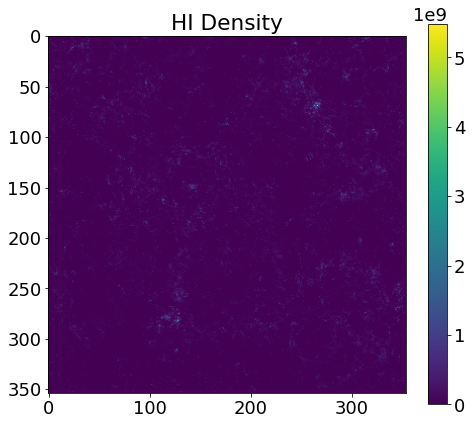

In [78]:
plt.imshow(rho_HI[:, :, 3])
plt.title('HI Density')
plt.colorbar()

In [59]:
map_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1

In [75]:
np.shape(rho_HI[:, :, 0])

(354, 354)

In [60]:
map_zs

array([5.80974359, 5.88031088, 5.95235602, 6.02592593, 6.10106952,
       6.17783784, 6.25628415, 6.33646409, 6.41843575, 6.50225989,
       6.588     , 6.67572254, 6.76549708, 6.85739645, 6.95149701,
       7.04787879, 7.14662577, 7.24782609, 7.35157233, 7.45796178,
       7.56709677])

In [62]:
z_med = np.median(map_zs)

In [ ]:
def HI_tb():
    return 189*h*((H0*(1 + z)**2)/H_func(z_med))*(rho_HI/rho_c)

In [83]:
rho_c = rho_c.to(u.Msun/(u.Mpc**3))

In [84]:
rho_c

<Quantity 1.35992947e+11 solMass / Mpc3>

In [85]:
HI_tb = 189*h*((H_0*(1 + z_med)**2)/H_func(z_med))*(rho_HI/rho_c)

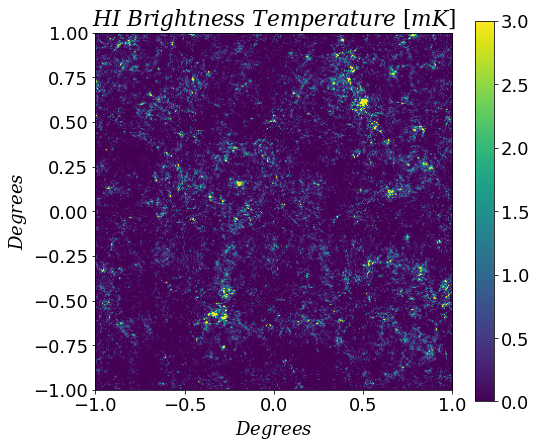

In [134]:
plt.imshow(HI_tb[:, :, 3], vmax = 3, cmap =  'viridis', extent = [-1, 1, -1, 1])
plt.title(r'$HI\ Brightness\ Temperature\ [mK]$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$Degrees$', math_fontfamily = 'dejavuserif')
plt.ylabel(r'$Degrees$', math_fontfamily = 'dejavuserif')
plt.colorbar()
plt.savefig('doga_HI_cb.jpeg')

In [99]:
rho_c

<Quantity 1.35992947e+11 solMass / Mpc3>

In [102]:
np.shape(HI_tb)

(354, 354, 21)

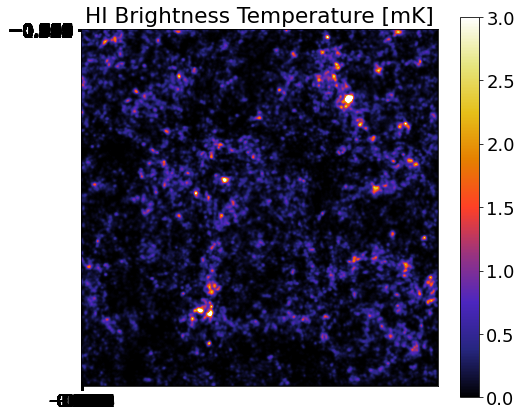

In [103]:
plt.imshow(gaussian_filter(HI_tb[:, :, 3],1), vmax = 3,cmap='CMRmap')
plt.title('HI Brightness Temperature [mK]')
plt.xticks(np.linspace(-1, 1, 354))
plt.yticks(np.linspace(-1, 1, 354))
plt.colorbar()